In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
classes = ["Balcony", "Bar", "Bathroom", "Bedroom", "Business Centre", "Dining room", "Exterior",
           "Gym", "Living room", "Lobby", "Patio", "Pool", "Restaurant", "Sauna", "Spa"]


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
num_epochs = 20
batch_size = 32
learning_rate = 0.001


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet statistics
])

In [6]:
dataset = ImageFolder("Dataset/", transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print("Train Size : " + str(train_size));
print("Test Size : " + str(test_size))

Train Size : 59196
Test Size : 14799


In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [12]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, len(classes))
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate the custom model
model = CNNModel(num_classes=len(classes)).to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [14]:
total_step = len(train_loader)
print("Total Steps : " + str(total_step))

Total Steps : 1850


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize lists to store loss and accuracy values
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_correct = 0
    total_samples = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        # Print training progress
        if (i + 1) == total_step:
            print(f"Epoch [{epoch + 1}/{num_epochs}]"
                  f"Train Loss: {loss.item():.4f}, Train Accuracy: {(total_correct / total_samples) * 100:.2f}%")
            
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0

                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
        
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
        
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
    
                print(f"Test Accuracy: {(100 * correct / total):.2f}%")
                print("")
        
        if epoch == num_epochs - 1:
            model.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                all_predicted = []
                all_labels = []

                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
    
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
    
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    # Collect predicted and true labels for classification report
                    all_predicted.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            avg_precision = precision_score(all_labels, all_predicted, average='macro')
            avg_recall = recall_score(all_labels, all_predicted, average='macro')
            avg_f1_score = f1_score(all_labels, all_predicted, average='macro')

            print(f"Average Precision: {avg_precision:.4f}")
            print(f"Average Recall: {avg_recall:.4f}")
            print(f"Average F1-Score: {avg_f1_score:.4f}")
            print("")
            train_losses.append(loss.item())
            train_accuracies.append((total_correct / total_samples) * 100)

Epoch [1/20] Train Loss: 0.7816, Train Accuracy: 49.12%
Test Accuracy: 47.82%

Epoch [2/20] Train Loss: 0.5903, Train Accuracy: 61.24%
Test Accuracy: 59.41%

Epoch [3/20] Train Loss: 0.4421, Train Accuracy: 69.58%
Test Accuracy: 67.55%

Epoch [4/20] Train Loss: 0.3357, Train Accuracy: 75.92%
Test Accuracy: 73.89%

Epoch [5/20] Train Loss: 0.2691, Train Accuracy: 80.17%
Test Accuracy: 78.24%

Epoch [6/20] Train Loss: 0.2214, Train Accuracy: 83.75%
Test Accuracy: 81.79%

Epoch [7/20] Train Loss: 0.1855, Train Accuracy: 86.84%
Test Accuracy: 84.62%

Epoch [8/20] Train Loss: 0.1563, Train Accuracy: 89.47%
Test Accuracy: 87.11%

Epoch [9/20] Train Loss: 0.1308, Train Accuracy: 91.62%
Test Accuracy: 89.25%

Epoch [10/20] Train Loss: 0.1137, Train Accuracy: 93.34%
Test Accuracy: 90.98%

Epoch [11/20] Train Loss: 0.0984, Train Accuracy: 94.12%
Test Accuracy: 91.76%

Epoch [12/20] Train Loss: 0.0872, Train Accuracy: 94.31%
Test Accuracy: 91.95%

Epoch [13/20] Train Loss: 0.0769, Train Accuracy:

In [19]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Test Accuracy: {(100 * correct / total):.2f}%")

Test Accuracy: 93.86%


In [18]:
model_path = "customcnn.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved at: {model_path}")

Model saved at: customcnn.pth


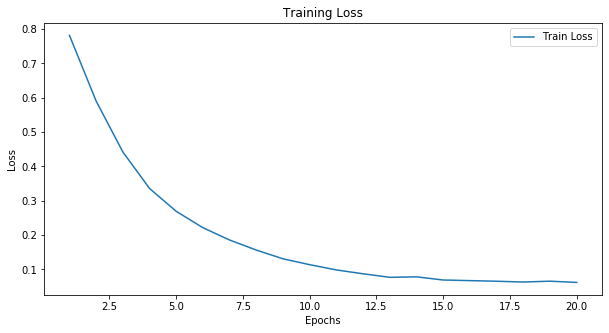

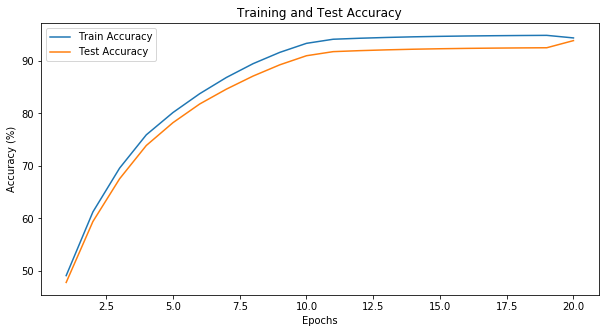

In [3]:
import matplotlib.pyplot as plt

# Plotting the graphs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
